In [1]:
from PIL import Image

In [2]:
import os

In [3]:
os.listdir("/kaggle/input/capital-alphabets-28x28")

['dataset', 'datasetSmall', 'datasetDigit']

# 1-Data 

In [4]:
import glob

In [5]:
files_paths=["/kaggle/input/capital-alphabets-28x28/dataset/train","/kaggle/input/capital-alphabets-28x28/datasetDigit/train","/kaggle/input/capital-alphabets-28x28/datasetSmall/train"]
classes=[]
labels=[]
images_path=[]
i=0
for path in files_paths:
    for inner_path in os.listdir(path):
        fullpath=os.path.join(path,inner_path)
        classe=inner_path.split("/")[-1]
        classes.append(classe)
        images_path+=[os.path.join(fullpath,img) for img in os.listdir(fullpath)]
        labels+=[i for img in os.listdir(fullpath)]
        i+=1

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

### a-Creating Dataframe and Classes Encoder

In [7]:
Data=pd.DataFrame({"img_path":images_path,"label":labels})


In [8]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
classes_to_encode=np.array([[i] for i in range(len(classes))])

In [10]:
encoder=OneHotEncoder().fit(classes_to_encode)

In [11]:
encoder.transform([[0],[23]]).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
Data=Data.sample(frac=0.6)

In [13]:
Data=Data.reset_index()
Data=Data.drop("index",axis=1)

In [14]:
Data.to_csv('handwritten-dataset.csv',index=False)

In [15]:
Data

,img_path,label
0,/kaggle/input/capital-alphabets-28x28/datasetD...,34
1,/kaggle/input/capital-alphabets-28x28/datasetD...,32
2,/kaggle/input/capital-alphabets-28x28/dataset/...,18
3,/kaggle/input/capital-alphabets-28x28/datasetD...,27
4,/kaggle/input/capital-alphabets-28x28/datasetS...,56
...,...,...
292331,/kaggle/input/capital-alphabets-28x28/datasetD...,31
292332,/kaggle/input/capital-alphabets-28x28/dataset/...,13
292333,/kaggle/input/capital-alphabets-28x28/datasetD...,31
292334,/kaggle/input/capital-alphabets-28x28/datasetD...,32


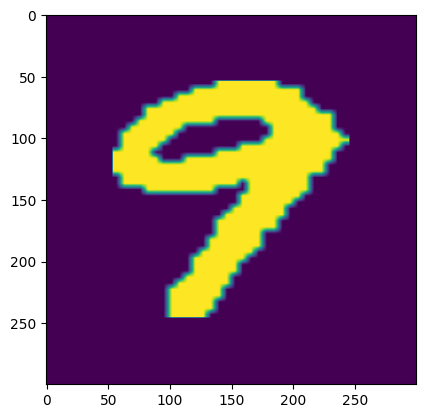

In [16]:
img=Data["img_path"][0]
image=Image.open(img)
plt.imshow(image)

In [17]:
from torchvision.transforms.functional import pil_to_tensor,to_pil_image

In [18]:
pil_to_tensor(image)/255

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

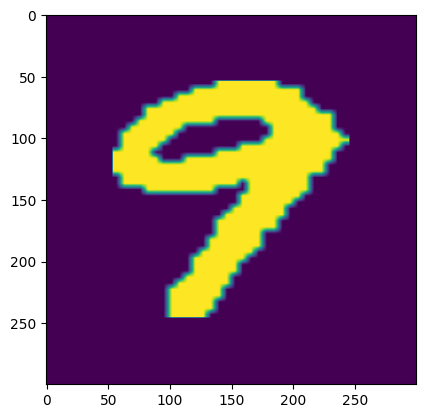

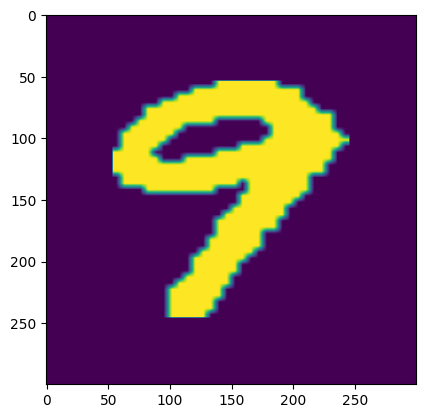

In [19]:
plt.imshow(np.array(to_pil_image(pil_to_tensor(image))))
plt.show()
plt.imshow(np.array(to_pil_image(pil_to_tensor(image))))
plt.show()

In [20]:
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn

In [21]:
torch.from_numpy(np.array(image)).shape

torch.Size([300, 300])

In [22]:
class Char_dataset(Dataset):
    def __init__(self):
        self.paths=Data["img_path"]
        self.labels=Data["label"]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,index):
        img=self.paths[index]
        image=Image.open(img)
        image=pil_to_tensor(image)
        label=self.labels[index]
        label=encoder.transform([[label]]).toarray() #one hot encoded label
        return image/255,label[0] #to get the vector of label because label is a nested list

# 2-Models and training 

In [23]:
input_size=162
batch_size=64
n_epochs=10
device="cuda" if torch.cuda.is_available() else "cpu"

In [24]:
char_data=Char_dataset()
char_loader=DataLoader(dataset=char_data,batch_size=batch_size,shuffle=True)

In [25]:
import torch.optim as optim

In [26]:
device

'cuda'

### a-Creating Discriminator and Generator

In [27]:
discriminator=nn.Sequential(#nn.Conv2d(1,1,3),
                            nn.Conv2d(1,1,kernel_size=(3, 3), padding=(1, 1)),#because i had a problem that the layer before was reducing shape
                            nn.Flatten(),
                            nn.Linear(300*301,1024),
                            #nn.BatchNorm1d(1024),
                            nn.LayerNorm(1024),
                            nn.ReLU(),
                            #nn.Linear(1024,1024),
                            #nn.ReLU(),
                            nn.Dropout(p=0.4),
                            nn.Linear(1024,256),
                            nn.LayerNorm(256),
                            nn.LeakyReLU(),
                            #nn.BatchNorm1d(256),
                            nn.Linear(256,1),
                            nn.Sigmoid())
#class Discriminator(nn.Module)
discriminator=discriminator.to(device)

In [28]:
generator = nn.Sequential(
    nn.Linear(input_size, 512*6*6),
    nn.Unflatten(1, (512, 6, 6)),  # Output shape: (batch_size, channels, height, width)
    nn.ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=1, padding=2),  # Output shape: (batch_size, 256, 6, 6)
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Upsample(scale_factor=5),  # Upsample to (256, 30, 30)
    nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=1, padding=2),  # Output shape: (batch_size, 128, 30, 30)
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),  # Upsample to (128, 60, 60)
    nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=1, padding=2),  # Output shape: (batch_size, 64, 60, 60)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Upsample(scale_factor=5),  # Upsample to (64, 300, 300)
    nn.ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=1, padding=2),  # Output shape: (batch_size, 1, 300, 300)
    nn.Sigmoid()  # Assuming this is used for binary image generation
)
generator=generator.to(device)

In [29]:
generator.state_dict()
data={"generator_dict":generator.state_dict()}
torch.save(data,"data.pth")

In [30]:
noise=np.random.randn(2,100)
images_class=encoder.transform([[0],[23]]).toarray()
image_array=generator(torch.from_numpy(np.concatenate((noise,images_class),axis=1)).float().to(device)).detach().to('cpu').numpy()

In [31]:
image_array=image_array[0].reshape((300,300))*255

In [32]:
image_array=image_array.astype('uint8')

In [33]:
image_array.shape

(300, 300)

In [34]:
criterion=nn.BCELoss()

In [35]:
disc_optimizer=optim.Adam(params=discriminator.parameters(),lr=0.0001)
gen_optimizer=optim.Adam(params=generator.parameters(),lr=0.0001)

### b-Training Loop 

loss 0.47817882821848695 for 1/10
loss 1.6511248538560916 for 1/10


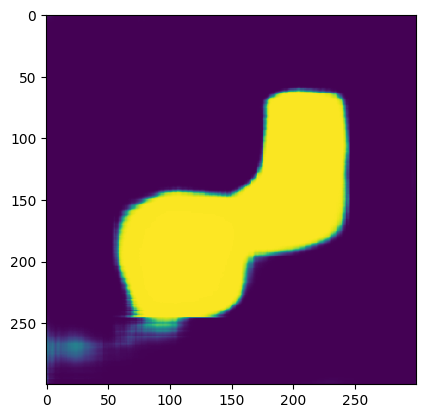

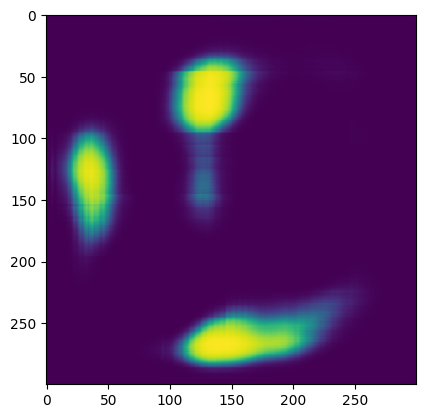

loss 0.430848567903567 for 2/10
loss 1.6078343825307129 for 2/10


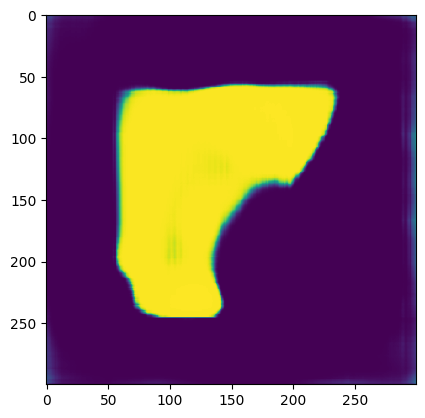

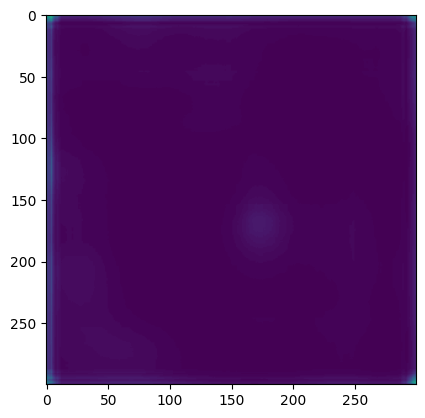

loss 0.2782654761185465 for 3/10
loss 2.345383639928547 for 3/10


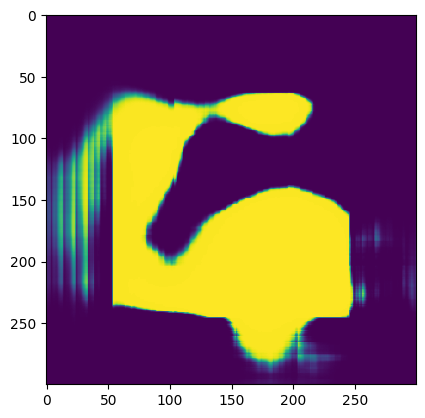

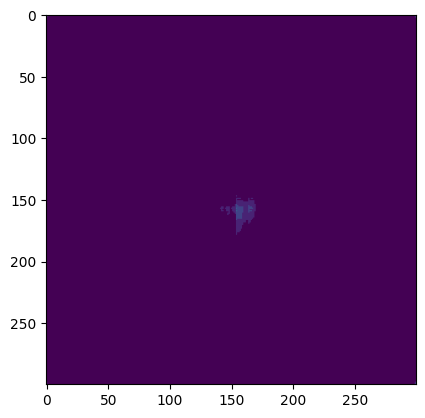

loss 0.21028685407709385 for 4/10
loss 3.0156690270204467 for 4/10


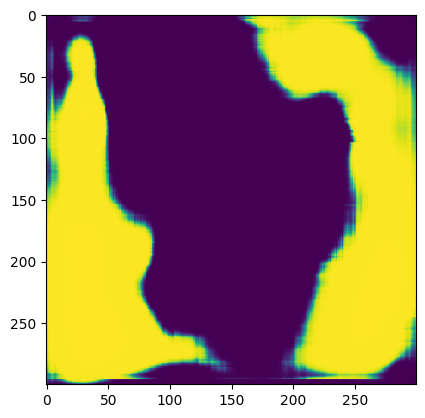

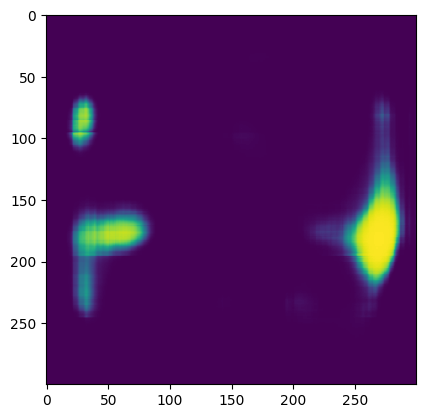

loss 0.11106150614790472 for 5/10
loss 4.424260142805697 for 5/10


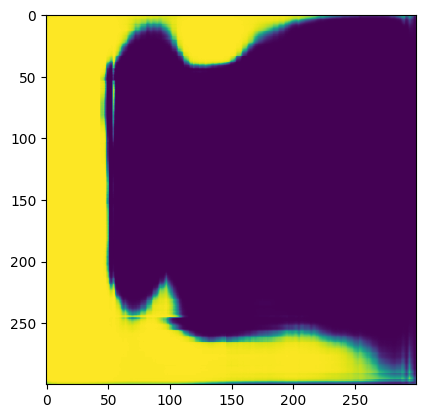

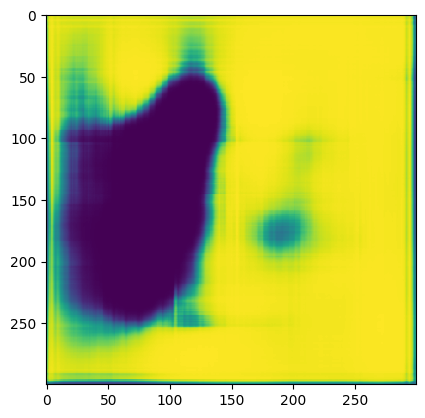

loss 0.17257594091118122 for 6/10
loss 3.2564877983632834 for 6/10


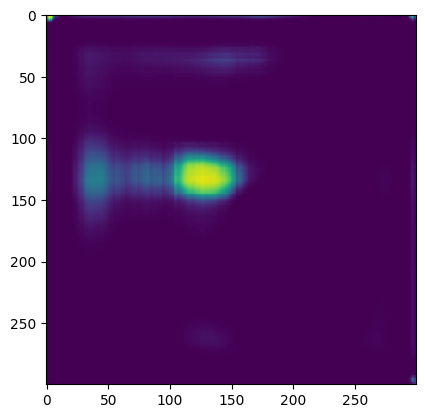

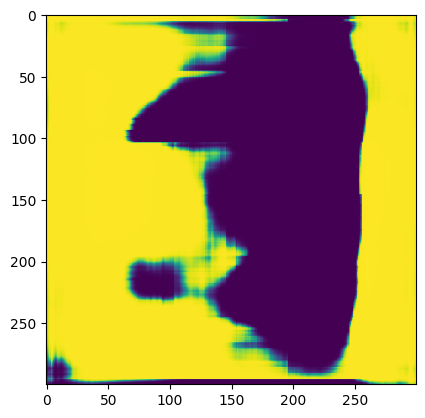

loss 0.07169274448128841 for 7/10
loss 3.579017090400756 for 7/10


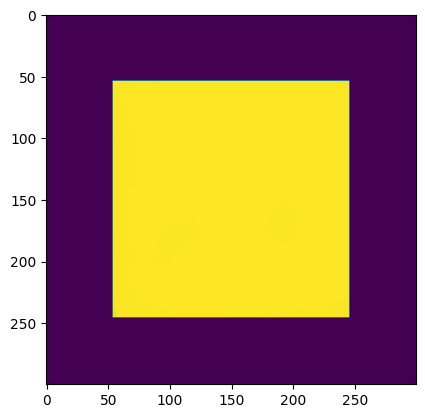

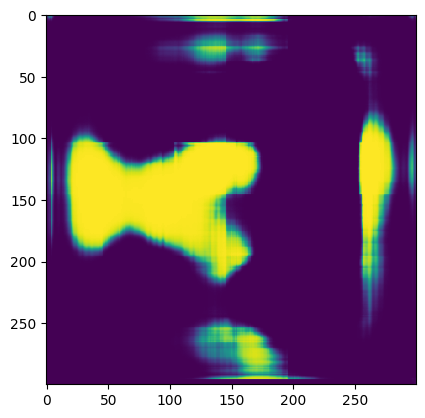

loss 0.2768389665724644 for 8/10
loss 2.63765151050405 for 8/10


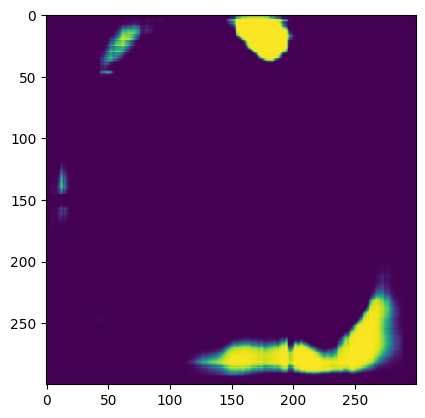

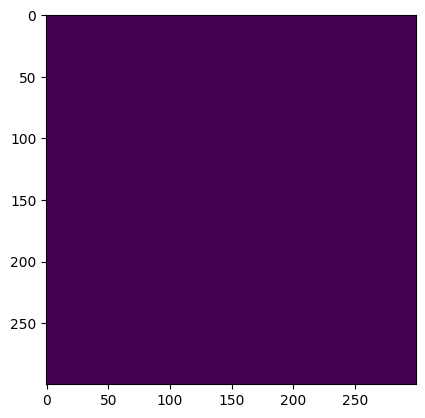

loss 0.214165072416715 for 9/10
loss 3.1139500072640214 for 9/10


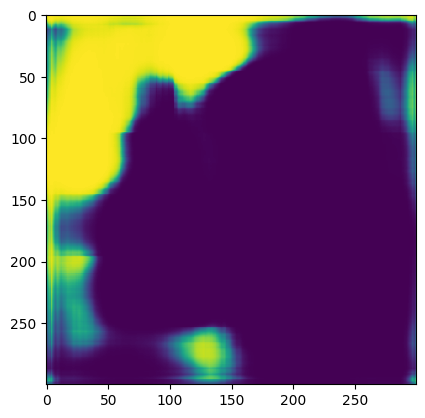

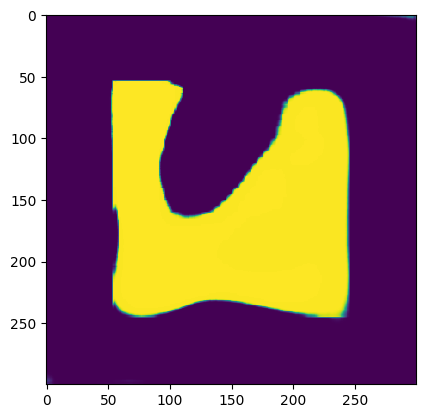

loss 0.13995923853932754 for 10/10
loss 3.378352291203526 for 10/10


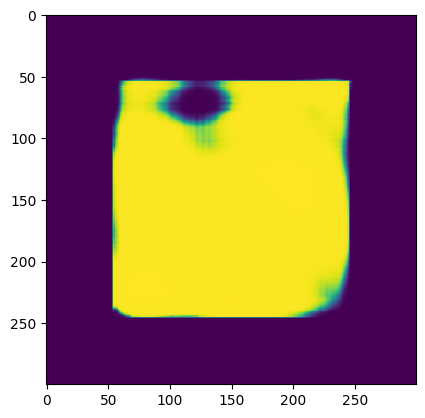

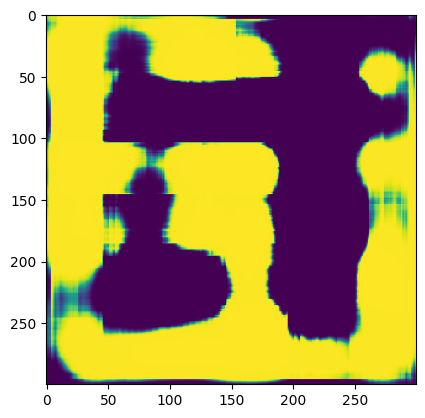

In [36]:
for epoch in range(n_epochs):
    generator_loss=0
    discriminator_loss=0
    for data in char_loader:
        #setting gradient of discriminator at zero
        disc_optimizer.zero_grad()
        
        #getting real data
        real_images,classes=data[0].to(device),data[1].to(device)
        real_images=real_images.float()
        reshape_layer1=nn.Linear(62,300)
        reshape_layer1=reshape_layer1.to(device)
        reshape_layer2=nn.Unflatten(1,(1,300,1)) #because the image has (1,300,300) shape
        reshape_layer2=reshape_layer2.to(device)
        #print(classes.size())
        #print(reshape_layer2(reshape_layer1(classes.float())).size())
        #print(real_images.size())
        classes_reshape=reshape_layer2(reshape_layer1(classes.float()))
        real_images_classes=torch.cat((real_images,classes_reshape),3)
        real_labels=torch.ones((real_images.shape[0],1)) #we choose 0 to get the batch size and this means that this images are real
        real_labels=real_labels.to(device)
        #getting fake data
        noise=torch.rand((real_images.shape[0],100))
        noise=noise.float()
        noise=noise.to(device)
        noise_with_class=torch.cat((noise,classes.float()),1)
        fake_images=generator(noise_with_class)#.detach()
        #print("size of fake images ",fake_images.size())
        fake_images_classes=torch.cat((fake_images,classes_reshape),3)
        fake_labels=torch.zeros((real_images.shape[0],1))
        fake_labels=fake_labels.to(device)
        #merging the fake and real data
        data=torch.cat((real_images_classes,fake_images_classes),0)
        #print("size of data ",data.shape)
        labels=torch.cat((real_labels,fake_labels),0)
        #predicting class
        pred=discriminator(data)
        #calculating L1 and L2 term
        #L1_term=torch.tensor(0.,requires_grad=True)
        #L2_term=torch.tensor(0.,requires_grad=True)
        #nweights=0
        #for name,weights in model.named_parameters():
        #    if 'bias' not in name:
        #        l1_weights_sum=torch.sum(torch.abs(weights))
        #        l2_weights_sum=torch.sum(torch.square(weights))
        #       L1_term=L1_term+l1_weights_sum
        #        L2_term=L2_term+l2_weights_sum
        #        nweights+=weights.numel()
        #L1_term=L1_term/ nweights
        #L2_term=L2_term/ nweights
        #disc loss
        disc_loss=criterion(pred,labels)
        #loss=loss+L1_term*l1_lambda# +L2_term*l2_lambda #regularizing loss
        disc_loss.backward(retain_graph=True)
        #updating discriminator params
        disc_optimizer.step()
        discriminator_loss += disc_loss.item()
        #setting gradiant of generator at zero
        gen_optimizer.zero_grad()
        #generator loss
        pred=discriminator(fake_images_classes)
        labels=torch.ones((real_images.shape[0],1))
        labels=labels.to(device)
        gen_loss=criterion(pred,labels)
        gen_loss.backward()
        #updating generator params
        gen_optimizer.step()
        generator_loss += gen_loss.item()
    epoch_disc_loss = discriminator_loss / len(char_loader)
    epoch_gen_loss = generator_loss / len(char_loader)
    print(f'loss {epoch_disc_loss} for {epoch+1}/{n_epochs}')
    print(f'loss {epoch_gen_loss} for {epoch+1}/{n_epochs}')
    #testing generated images
    noise=np.random.randn(2,100)
    images_class=encoder.transform([[0],[23]]).toarray()
    images_array=generator(torch.from_numpy(np.concatenate((noise,images_class),axis=1)).float().to(device)).detach().to('cpu').numpy()
    i=0 #is the index of current image
    for image in images_array:
        image=image.reshape((300,300))*255
        image=image.astype('uint8')
        raw_image=Image.fromarray(image)
        raw_image.save("image"+str(i)+"_epoch_"+str(epoch+1)+".png")
        plt.imshow(image)
        plt.show()
    #train_l.append(epoch_loss)

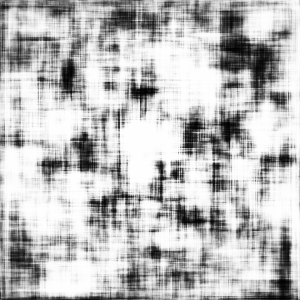

In [37]:
Image.fromarray(image_array)

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
Data=train_test_split(Data,train_size=1,shuffle=True)